<a href="https://colab.research.google.com/github/Michele-Maestrini/FusionCore_v0/blob/main/FusionCore_v0_EDA_01_FD00x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FusionCore v0 — EDA 01: CMAPSS FD00x Diagnostic Overview

**Purpose**  
This notebook performs diagnostic exploratory analysis of NASA CMAPSS FD00x datasets to surface **failure dynamics**, **sensor stability**, and **cross-dataset variability** that materially affect **model benchmarking** and **architectural risk** in FusionCore v0.

**Scope**
- Research and diagnostics only  
- No model training  
- No hyperparameter optimisation  
- No production assumptions


## Risk Questions Addressed

This notebook explicitly investigates the following risks:

- How consistent are degradation trajectories across engines and datasets?
- Which sensors exhibit instability, near-constant behaviour, or non-monotonic patterns?
- How early do degradation signals emerge relative to end-of-life?
- Are there distribution shifts across FD001–FD004 that threaten generalisation?

Outputs from this analysis feed directly into FusionCore v0 benchmarking (TFT vs TS Mixer vs AutoGluon).


## Commercial Modular Aero-Propulsion System Simulation (CMAPSS)
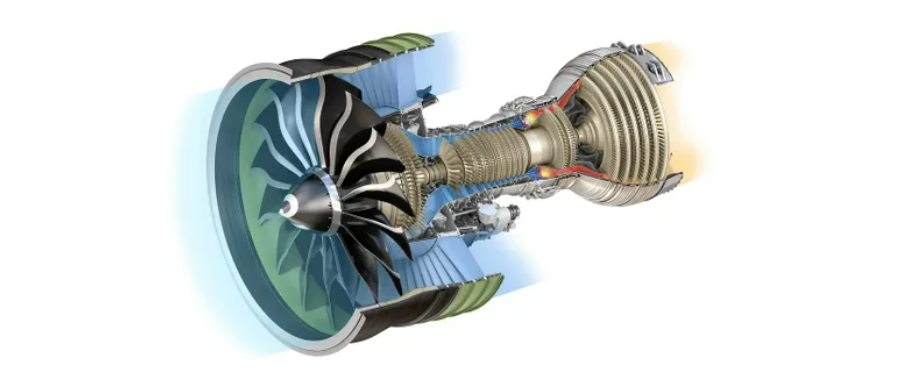

### Turbofan Engine Degradation

Each FD00x dataset contains multiple multivariate time series (one per engine). Each row is one operational cycle.

### Column Schema

The raw text files contain **26 numeric columns**:

- $1$ engine identifier (`unit_id`)
- $1$ time index in cycles (`cycle`)
- $3$ operating settings (`op_setting_1..3`)
- $21$ sensor measurements (`sensor_1..sensor_21`)

$$26 = 1 + 1 + 3 + 21$$

### Train -Vs- Test

- **Train**: each engine is observed from an initial healthy state until failure.  
- **Test**: each engine trajectory ends some cycles before failure.  
- **RUL files** provide a vector of true remaining useful life values for the **final cycle of each test engine** (one value per test trajectory).

### Fd00x Dataset Properties

| Dataset | Train engines | Test engines | Operating regimes | Fault modes |
|---|---:|---:|---:|---:|
| FD001 | 100 | 100 | 1 | 1 (HPC) |
| FD002 | 260 | 259 | 6 | 1 (HPC) |
| FD003 | 100 | 100 | 1 | 2 (HPC, Fan) |
| FD004 | 248 | 249 | 6 | 2 (HPC, Fan) |

*HPC = High-Pressure Compressor.*

### Objective

Given the observed history of an engine up to cycle $t$, predict its remaining useful life (RUL) in cycles:

$$\mathrm{RUL}(t) = T_{\text{fail}} - t$$

where $T_{\text{fail}}$ is the (unknown) failure cycle for that engine.

[Reference](https://ieeexplore.ieee.org/document/4711414): A. Saxena, K. Goebel, D. Simon, and N. Eklund, *Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation*, PHM 2008.



## **Training Units**
They refer to the **number of distinct engines** (independent run-to-failure trajectories) in the **training set**.

Each *unit* = **one engine**

Each unit provides **one multivariate time series** from initial operation until failure (training only).

---

### What Is A “unit”?

Let:

* $i$  = engine (unit) index
* $t$ = cycle (time index)
* $x_{i}(t) \in \mathbb{R}^{d}$  = sensor vector at cycle $t$

A **training unit** is the full sequence:
$$
{x_i(1), x_i(2), \ldots, x_i(T_i)}
$$
where:

* $T_i$ = failure cycle of engine $i$
* $T_i$ varies across engines

---

### Why They Are Called “Training Units”

* The **unit** is the *statistical sample*
* Cycles within a unit are **not independent**
* Independence is assumed **across units**, not across rows

This is critical for:

* correct train/validation splits
* avoiding temporal leakage
* model evaluation

---

### How This Looks In The Data

| Column    | Meaning                                   |
| --------- | ----------------------------------------- |
| `unit_id` | Engine identifier (training unit ID)      |
| `cycle`   | Time index within that engine             |
| Sensors   | Observations at that cycle                |
| `RUL`     | Remaining life at that cycle (train only) |

Example:

* `unit_id = 17`
* `cycle = 1 … 192`

  $→$ **1 training unit**, **192 rows**

---

### Training Units Per Dataset

| Dataset | Training units | Meaning                                  |
| ------- | -------------: | ---------------------------------------- |
| FD001   |            100 | 100 engines, single regime, single fault |
| FD002   |            260 | 260 engines, multiple regimes            |
| FD003   |            100 | 100 engines, multiple fault modes        |
| FD004   |            248 | 248 engines, multiple regimes & faults   |



---
*Training units correspond to distinct engines, each providing one independent run-to-failure multivariate time series. Individual cycles within a unit are temporally dependent and must not be treated as independent samples.*

# Libraries

In [ ]:
from google.colab import drive
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

# Environment Setup

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List available CMAPSS dataset files
DATA_DIR = "/content/drive/MyDrive/PI/Datasets"
files = sorted(os.listdir(DATA_DIR))

cmapss_files = [f for f in files if f.startswith(("train_FD", "test_FD", "RUL_FD"))]
cmapss_files

['RUL_FD001.txt',
 'RUL_FD002.txt',
 'RUL_FD003.txt',
 'RUL_FD004.txt',
 'test_FD001.txt',
 'test_FD002.txt',
 'test_FD003.txt',
 'test_FD004.txt',
 'train_FD001.txt',
 'train_FD002.txt',
 'train_FD003.txt',
 'train_FD004.txt']

# EDA Across FD001–FD004

This section repeats the same checks and visuals for **FD002, FD003, and FD004**, enabling direct comparison while keeping preprocessing identical.

Key quantities reported per dataset:
- row counts and engine counts
- missing values
- lifecycle length distribution (cycles to failure)
- RUL distribution (train, derived)
- sensor variance profile (log-scale; top/bottom highlighted)

For multi-regime datasets (FD002, FD004), an additional plot shows the structure of operating settings.

In [ ]:
# Creating a canonical loader
def infer_cmapss_schema(train_path: str):
    """
    Infers number of columns in the CMAPSS file and builds column names.
    CMAPSS layout:
      [unit_id, cycle, op1, op2, op3, sensor_1 ... sensor_k]
    Total columns = 5 + k
    """
    # Read just 1 row to infer number of columns robustly
    sample = pd.read_csv(train_path, sep=r"\s+", header=None, nrows=1)
    n_cols = sample.shape[1]
    if n_cols < 6:
        raise ValueError(f"Unexpected column count ({n_cols}). Check file format: {train_path}")

    num_sensors = n_cols - 5
    cols = (
        ["unit_id", "cycle"] +
        [f"op_setting_{i}" for i in range(1, 4)] +
        [f"sensor_{i}" for i in range(1, num_sensors + 1)]
    )
    return cols, num_sensors, n_cols

def load_fd(fd: str, data_dir: str = DATA_DIR):
    """
    Loads train/test/RUL for a given FD dataset (FD001..FD004),
    applies inferred schema, and derives training RUL.
    """
    train_path = os.path.join(data_dir, f"train_{fd}.txt")
    test_path  = os.path.join(data_dir, f"test_{fd}.txt")
    rul_path   = os.path.join(data_dir, f"RUL_{fd}.txt")

    cols, num_sensors, n_cols = infer_cmapss_schema(train_path)

    train_df = pd.read_csv(train_path, sep=r"\s+", header=None, names=cols)
    test_df  = pd.read_csv(test_path,  sep=r"\s+", header=None, names=cols)
    rul_df   = pd.read_csv(rul_path,   header=None, names=["RUL"])

    # Derive training RUL: max_cycle(unit) - cycle
    max_cycle = train_df.groupby("unit_id")["cycle"].max()
    train_df = train_df.join(max_cycle, on="unit_id", rsuffix="_max")
    train_df["RUL"] = train_df["cycle_max"] - train_df["cycle"]
    train_df.drop(columns=["cycle_max"], inplace=True)

    # Sanity checks
    train_units = train_df["unit_id"].nunique()
    test_units  = test_df["unit_id"].nunique()

    # Cycle monotonicity per unit (train)
    bad_units = []
    for uid, g in train_df.groupby("unit_id", sort=False):
        if not g["cycle"].is_monotonic_increasing:
            bad_units.append(uid)

    meta = {
        "fd": fd,
        "n_cols_in_file": n_cols,
        "num_sensors_inferred": num_sensors,
        "train_shape": train_df.shape,
        "test_shape": test_df.shape,
        "rul_shape": rul_df.shape,
        "train_units": train_units,
        "test_units": test_units,
        "non_monotonic_train_units": len(bad_units),
        "bad_unit_ids_sample": bad_units[:10],
    }

    return train_df, test_df, rul_df, meta

def dataset_summary(train_df, test_df, rul_df, meta):
    # Derived training RUL already present in train_df
    lifecycle = train_df.groupby("unit_id")["cycle"].max()
    out = {
        "dataset": meta["fd"],
        "train_rows": len(train_df),
        "test_rows": len(test_df),
        "train_engines": train_df["unit_id"].nunique(),
        "test_engines": test_df["unit_id"].nunique(),
        "missing_train": int(train_df.isna().sum().sum()),
        "missing_test": int(test_df.isna().sum().sum()),
        "lifecycle_min": int(lifecycle.min()),
        "lifecycle_median": float(lifecycle.median()),
        "lifecycle_max": int(lifecycle.max()),
        "RUL_min": float(train_df["RUL"].min()),
        "RUL_median": float(train_df["RUL"].median()),
        "RUL_max": float(train_df["RUL"].max()),
        "n_cols_raw": meta["n_cols_in_file"],
        "n_sensors": meta["num_sensors_inferred"],
    }
    return out

def plot_rul_distribution(train_df, title_suffix=""):
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df["RUL"], bins=50)
    plt.title(f"RUL Distribution (Train) {title_suffix}".strip())
    plt.xlabel("RUL (Cycles)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def plot_lifecycle_lengths(train_df, k=10, title_suffix=""):
    lifecycle_df = (
        train_df.groupby("unit_id")["cycle"]
        .max()
        .reset_index(name="lifecycle_length")
        .sort_values("lifecycle_length", ascending=False)
    )

    top_k = lifecycle_df.nlargest(k, "lifecycle_length")["unit_id"].astype(str).tolist()
    bottom_k = lifecycle_df.nsmallest(k, "lifecycle_length")["unit_id"].astype(str).tolist()

    plot_df = lifecycle_df.copy()
    plot_df["unit_id"] = plot_df["unit_id"].astype(str)

    def label(u):
        if u in top_k: return f"Top {k}"
        if u in bottom_k: return f"Bottom {k}"
        return "Middle"

    plot_df["group"] = plot_df["unit_id"].map(label)

    # Lock ordering
    plot_df["unit_id"] = pd.Categorical(plot_df["unit_id"], categories=plot_df["unit_id"].tolist(), ordered=True)

    palette = {f"Top {k}": sns.color_palette("bright")[0],
               f"Bottom {k}": sns.color_palette("bright")[1],
               "Middle": "#8a8a8a"}

    plt.figure(figsize=(9, 10))
    ax = sns.barplot(data=plot_df, y="unit_id", x="lifecycle_length",
                     hue="group", palette=palette, orient="h")
    ax.set_title(f"Engine Lifecycle Lengths (Train) {title_suffix}".strip())
    ax.set_xlabel("Cycles to Failure")
    ax.set_ylabel("Engine ID")

    # Thin y labels
    step = 10 if plot_df["unit_id"].nunique() > 60 else 5
    yticks = ax.get_yticks()
    ylabels = ax.get_yticklabels()
    ax.set_yticks(yticks[::step])
    ax.set_yticklabels([lab.get_text() for lab in ylabels[::step]])

    ax.legend(title="Group", frameon=False, loc="best")
    plt.tight_layout()
    plt.show()

def plot_sensor_variance(train_df, k=5, title_suffix=""):
    sensor_cols = [c for c in train_df.columns if c.startswith("sensor_")]
    sensor_variance = (
        train_df[sensor_cols].var().sort_values().reset_index()
        .rename(columns={"index":"sensor", 0:"variance"})
    )

    bottom_k = sensor_variance.nsmallest(k, "variance")["sensor"].tolist()
    top_k = sensor_variance.nlargest(k, "variance")["sensor"].tolist()

    def label(s):
        if s in top_k: return f"Top {k}"
        if s in bottom_k: return f"Bottom {k}"
        return "Middle"

    sv = sensor_variance.copy()
    sv["group"] = sv["sensor"].map(label)
    sv = sv.sort_values("variance", ascending=True)

    palette = {f"Top {k}": sns.color_palette("bright")[0],
               f"Bottom {k}": sns.color_palette("bright")[1],
               "Middle": "#8a8a8a"}

    plt.figure(figsize=(9, 7))
    ax = sns.barplot(data=sv, x="variance", y="sensor", hue="group", palette=palette, orient="h")
    ax.set_xscale("log")
    ax.set_title(f"Sensor Variance (Log Scale) {title_suffix}".strip())
    ax.set_xlabel("Variance (Log Scale)")
    ax.set_ylabel("Sensor")
    ax.legend(title="Group", frameon=False, loc="best")
    plt.tight_layout()
    plt.show()

    return sensor_variance

def plot_operating_settings(train_df, title_suffix=""):
    # Sample for speed/readability
    sample = train_df.sample(min(len(train_df), 8000), random_state=42)
    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=sample, x="op_setting_1", y="op_setting_2", s=12, alpha=0.4)
    plt.title(f"Operating Settings Structure {title_suffix}".strip())
    plt.xlabel("op_setting_1")
    plt.ylabel("op_setting_2")
    plt.tight_layout()
    plt.show()

def plot_random_engines_sensors(train_df, sensors_to_plot=("sensor_2","sensor_3","sensor_4"), n_engines=6, seed=42, title_suffix=""):
    rng = np.random.default_rng(seed=seed)
    engine_ids = rng.choice(train_df["unit_id"].unique(), size=n_engines, replace=False)

    sensor_palette = dict(zip(sensors_to_plot, sns.color_palette("bright", len(sensors_to_plot))))

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    axes = axes.flatten()

    for ax, uid in zip(axes, engine_ids):
        df_e = train_df[train_df["unit_id"] == uid].sort_values("cycle")
        for s in sensors_to_plot:
            sns.lineplot(data=df_e, x="cycle", y=s, ax=ax, color=sensor_palette[s])
        ax.set_title(f"Engine {uid}")
        ax.set_xlabel("Cycle")
        ax.set_ylabel("Sensor Value")

    # Remove unused
    for ax in axes[len(engine_ids):]:
        ax.remove()

    handles = [plt.Line2D([0],[0], color=sensor_palette[s], lw=2) for s in sensors_to_plot]
    fig.legend(handles, list(sensors_to_plot), title="Sensor", frameon=False,
               loc="lower center", ncol=len(sensors_to_plot))

    fig.suptitle(f"Sensor Evolution (Random Engines) {title_suffix}".strip(), fontsize=14, y=0.96)
    plt.tight_layout(rect=[0, 0.08, 1, 0.93])
    plt.show()


def plot_sensor_rul_corr_ranking(train_df, top_k=12, title_suffix="", method="pearson", tau=1e-12):
    """Rank sensors by absolute correlation with RUL.

    Parameters
    ----------
    train_df : pd.DataFrame
        Must include sensor_* columns and 'RUL'.
    top_k : int
        Number of sensors to display.
    method : {'pearson','spearman'}
        Correlation type. Spearman captures monotonic (possibly non-linear) association.
    tau : float
        Variance floor used to exclude near-constant sensors (avoids divide-by-zero warnings).
    """
    sensor_cols = [c for c in train_df.columns if c.startswith("sensor_")]

    # Exclude near-constant sensors to avoid invalid divisions in correlation
    var_s = train_df[sensor_cols].var()
    active = var_s[var_s >= tau].index.tolist()

    if len(active) == 0:
        print(f"No active sensors found (variance < {tau}) {title_suffix}".strip())
        return

    corr = train_df[active].corrwith(train_df["RUL"], method=method).dropna()

    plot_df = (
        corr.abs()
        .sort_values(ascending=False)
        .head(top_k)
        .reset_index()
        .rename(columns={"index": "sensor", 0: "abs_corr"})
    )

    plt.figure(figsize=(8.5, 4.8))
    ax = sns.barplot(data=plot_df, y="sensor", x="abs_corr", orient="h")
    ax.set_title(f"Top {top_k} Sensors by |{method} Corr(Sensor, RUL)| {title_suffix}".strip())
    ax.set_xlabel("|Correlation|")
    ax.set_ylabel("Sensor")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4.5))
    ax = sns.barplot(data=plot_df, y="sensor", x="abs_corr", orient="h")
    ax.set_title(f"Top {top_k} Sensors by |Corr(Sensor, RUL)| {title_suffix}".strip())
    ax.set_xlabel("|Correlation|")
    ax.set_ylabel("Sensor")
    plt.tight_layout()
    plt.show()



def plot_sensor_rul_corr_compare(train_df, top_k=12, title_suffix="", tau=1e-12):
    """Compare Pearson vs Spearman absolute correlation with RUL for top sensors.

    Produces a single bar chart (grouped by method) to avoid duplicate figures.
    """
    sensor_cols = [c for c in train_df.columns if c.startswith("sensor_")]

    # Exclude near-constant sensors
    var_s = train_df[sensor_cols].var()
    active = var_s[var_s >= tau].index.tolist()

    if len(active) == 0:
        print(f"No active sensors found (variance < {tau}) {title_suffix}".strip())
        return

    pear = train_df[active].corrwith(train_df["RUL"], method="pearson").dropna().abs()
    spear = train_df[active].corrwith(train_df["RUL"], method="spearman").dropna().abs()

    # Choose top_k sensors by the maximum absolute correlation across the two methods
    max_abs = pd.concat([pear.rename("pearson"), spear.rename("spearman")], axis=1).max(axis=1)
    top_sensors = max_abs.sort_values(ascending=False).head(top_k).index.tolist()

    plot_df = pd.DataFrame({
        "sensor": top_sensors,
        "pearson": pear.reindex(top_sensors).values,
        "spearman": spear.reindex(top_sensors).values
    }).melt(id_vars="sensor", var_name="method", value_name="abs_corr")

    # Preserve ranking order (top to bottom)
    plot_df["sensor"] = pd.Categorical(plot_df["sensor"], categories=top_sensors, ordered=True)

    plt.figure(figsize=(8.5, 4.8))
    ax = sns.barplot(data=plot_df, y="sensor", x="abs_corr", hue="method", orient="h")
    ax.set_title(f"Top {top_k} Sensors by |Corr(Sensor, RUL)| (Pearson vs Spearman) {title_suffix}".strip())
    ax.set_xlabel("|Correlation|")
    ax.set_ylabel("Sensor")
    ax.legend(title="Method", frameon=False, loc="best")
    plt.tight_layout()
    plt.show()

## Preview And Schema (FD001–FD004)

This section provides a compact preview of the raw inputs for each dataset:
- `train_FD00x`: multivariate run-to-failure trajectories
- `test_FD00x`: truncated trajectories (end before failure)
- `RUL_FD00x`: ground-truth remaining life for each test engine

For each FD dataset we show:
- `head()` previews for train/test/RUL
- a schema summary including column counts, inferred sensor count, and dtype breakdown

In [ ]:
fds = ["FD001","FD002","FD003","FD004"]

def dtype_breakdown(df: pd.DataFrame):
    counts = df.dtypes.value_counts()
    return {str(k): int(v) for k, v in counts.items()}

schema_rows = []
data_cache = {}

for fd in fds:
    train_df_d, test_df_d, rul_df_d, meta_d = load_fd(fd)
    data_cache[fd] = (train_df_d, test_df_d, rul_df_d, meta_d)

    # Clear labelled previews (no spacer table)
    display(Markdown(f"### {fd} — Train (head)"))
    display(train_df_d.head(3))

    display(Markdown(f"### {fd} — Test (head)"))
    display(test_df_d.head(3))

    display(Markdown(f"### {fd} — RUL Vector (head)"))
    display(rul_df_d.head(3))

    schema_rows.append({
        "dataset": fd,
        "train_rows": len(train_df_d),
        "test_rows": len(test_df_d),
        "train_engines": int(train_df_d["unit_id"].nunique()),
        "test_engines": int(test_df_d["unit_id"].nunique()),
        "raw_cols": int(meta_d["n_cols_in_file"]),
        "inferred_sensors": int(meta_d["num_sensors_inferred"]),
        "train_dtype_breakdown": dtype_breakdown(train_df_d.drop(columns=["RUL"], errors="ignore")),
        "test_dtype_breakdown": dtype_breakdown(test_df_d),
    })

schema_df = pd.DataFrame(schema_rows).set_index("dataset")
schema_df

### FD001 — Train (head)

,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189


### FD001 — Test (head)

,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


### FD001 — RUL Vector (head)

,RUL
0,112
1,98
2,69


### FD002 — Train (head)

,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146


### FD002 — Test (head)

,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.0,28.42,17.1551
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.0,24.29,14.8039
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.0,14.98,8.9125


### FD002 — RUL Vector (head)

,RUL
0,18
1,79
2,106


### FD003 — Train (head)

,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256


### FD003 — Test (head)

,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,521.89,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,521.85,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,522.10,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244


### FD003 — RUL Vector (head)

,RUL
0,44
1,51
2,27


### FD004 — Train (head)

,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213,318


### FD004 — Test (head)

,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,20.0072,0.700,100.0,491.19,606.67,1481.04,1227.81,9.35,...,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007
1,1,2,24.9984,0.620,60.0,462.54,536.22,1256.17,1031.48,7.05,...,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748
2,1,3,42.0000,0.842,100.0,445.00,549.23,1340.13,1105.88,3.91,...,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365


### FD004 — RUL Vector (head)

,RUL
0,22
1,39
2,107


,train_rows,test_rows,train_engines,test_engines,raw_cols,inferred_sensors,train_dtype_breakdown,test_dtype_breakdown
dataset,,,,,,,,
FD001,20631,13096,100,100,26,21,"{'float64': 22, 'int64': 4}","{'float64': 22, 'int64': 4}"
FD002,53759,33991,260,259,26,21,"{'float64': 22, 'int64': 4}","{'float64': 22, 'int64': 4}"
FD003,24720,16596,100,100,26,21,"{'float64': 22, 'int64': 4}","{'float64': 22, 'int64': 4}"
FD004,61249,41214,249,248,26,21,"{'float64': 22, 'int64': 4}","{'float64': 22, 'int64': 4}"


## Dataset Summary Table

The table below aggregates key structural and target statistics per dataset.  
Training RUL is derived as:

$$\mathrm{RUL}(t) = T_{\text{fail}} - t$$

where $T_{\text{fail}}$ is the last observed cycle for that training engine.

In [ ]:
def flatten_describe(prefix: str, s: pd.Series):
    d = s.describe()
    return {
        f"{prefix}_count": float(d["count"]),
        f"{prefix}_mean": float(d["mean"]),
        f"{prefix}_std": float(d["std"]),
        f"{prefix}_min": float(d["min"]),
        f"{prefix}_25": float(d["25%"]),
        f"{prefix}_50": float(d["50%"]),
        f"{prefix}_75": float(d["75%"]),
        f"{prefix}_max": float(d["max"]),
    }

def dataset_summary_expanded(train_df, test_df, rul_df, meta):
    lifecycle = train_df.groupby("unit_id")["cycle"].max()
    out = {
        "dataset": meta["fd"],
        "train_rows": int(len(train_df)),
        "test_rows": int(len(test_df)),
        "train_engines": int(train_df["unit_id"].nunique()),
        "test_engines": int(test_df["unit_id"].nunique()),
        "train_na_total": int(train_df.isna().sum().sum()),
        "test_na_total": int(test_df.isna().sum().sum()),
        "raw_cols": int(meta["n_cols_in_file"]),
        "inferred_sensors": int(meta["num_sensors_inferred"]),
    }
    out.update(flatten_describe("lifecycle", lifecycle))
    out.update(flatten_describe("rul", train_df["RUL"]))
    return out

summaries = []
for fd in ["FD001","FD002","FD003","FD004"]:
    train_df_d, test_df_d, rul_df_d, meta_d = data_cache.get(fd, load_fd(fd))
    summaries.append(dataset_summary_expanded(train_df_d, test_df_d, rul_df_d, meta_d))

summary_df = pd.DataFrame(summaries).set_index("dataset")
summary_df


,train_rows,test_rows,train_engines,test_engines,train_na_total,test_na_total,raw_cols,inferred_sensors,lifecycle_count,lifecycle_mean,...,lifecycle_75,lifecycle_max,rul_count,rul_mean,rul_std,rul_min,rul_25,rul_50,rul_75,rul_max
dataset,,,,,,,,,,,,,,,,,,,,,
FD001,20631,13096,100,100,0,0,26,21,100.0,206.310000,...,229.25,362.0,20631.0,107.807862,68.880990,0.0,51.0,103.0,155.0,361.0
FD002,53759,33991,260,259,0,0,26,21,260.0,206.765385,...,230.25,378.0,53759.0,108.154746,69.180569,0.0,51.0,103.0,156.0,377.0
FD003,24720,16596,100,100,0,0,26,21,100.0,247.200000,...,279.75,525.0,24720.0,138.077063,98.846675,0.0,61.0,123.0,190.0,524.0
FD004,61249,41214,249,248,0,0,26,21,249.0,245.979920,...,290.00,543.0,61249.0,133.311417,89.783389,0.0,61.0,122.0,190.0,542.0


## Summary Visualisations (FD001–FD004)

The plots below provide an at-a-glance view of:
- lifecycle variability across datasets (per-engine max cycle)
- RUL distribution variability across datasets
- train/test engine counts
- missing-value totals (expected to be zero for CMAPSS)

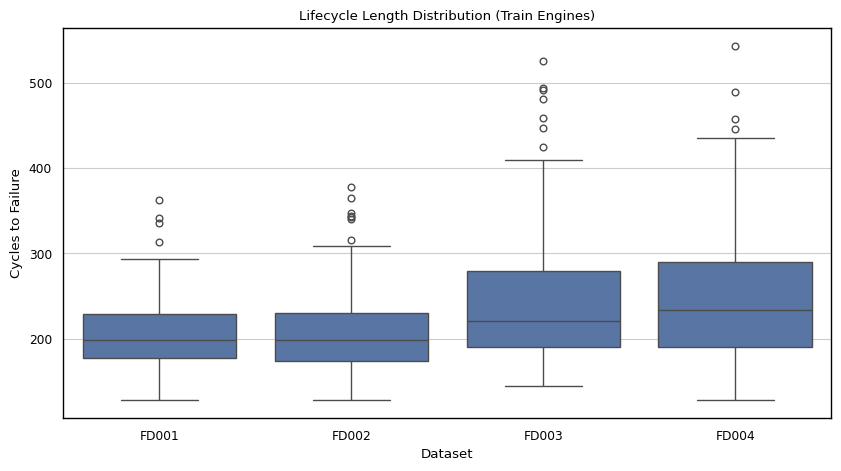

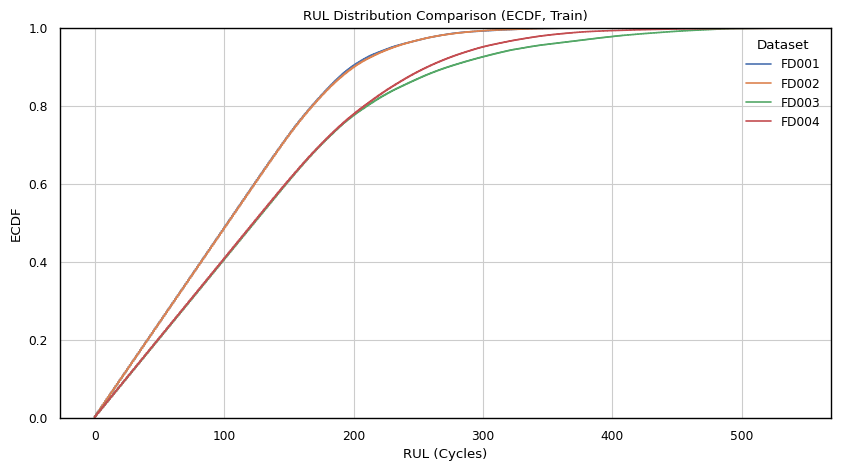

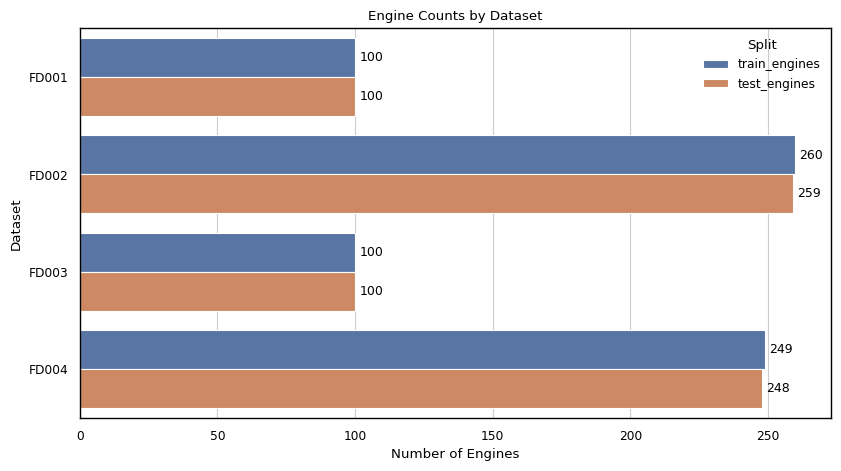

,train_na_total,test_na_total
dataset,,
FD001,0,0
FD002,0,0
FD003,0,0
FD004,0,0


In [ ]:
# Report styling
sns.set_theme(style="whitegrid", context="paper", font_scale=1.0)
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "axes.edgecolor": "black",
    "text.color": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
})

fds = ["FD001", "FD002", "FD003", "FD004"]
fds_cat = pd.CategoricalDtype(categories=fds, ordered=True)

# Assemble long-form frames
lifecycle_long, rul_long, counts_rows = [], [], []

for fd in fds:
    train_df_d, test_df_d, rul_df_d, meta_d = data_cache[fd]

    lifecycle = (
        train_df_d.groupby("unit_id")["cycle"]
        .max()
        .reset_index(name="lifecycle_length")
    )
    lifecycle["dataset"] = fd
    lifecycle_long.append(lifecycle)

    r = train_df_d[["RUL"]].copy()
    r["dataset"] = fd
    rul_long.append(r)

    counts_rows.append({
        "dataset": fd,
        "train_engines": int(train_df_d["unit_id"].nunique()),
        "test_engines": int(test_df_d["unit_id"].nunique()),
        "train_na_total": int(train_df_d.isna().sum().sum()),
        "test_na_total": int(test_df_d.isna().sum().sum()),
    })

lifecycle_long = pd.concat(lifecycle_long, ignore_index=True)
rul_long = pd.concat(rul_long, ignore_index=True)
counts_df = pd.DataFrame(counts_rows).set_index("dataset")

# Fix dataset ordering
lifecycle_long["dataset"] = lifecycle_long["dataset"].astype(fds_cat)
rul_long["dataset"] = rul_long["dataset"].astype(fds_cat)

# 1) Lifecycle distribution per dataset (boxplot)
plt.figure(figsize=(8.5, 4.8))
ax = sns.boxplot(data=lifecycle_long, x="dataset", y="lifecycle_length")
ax.set_title("Lifecycle Length Distribution (Train Engines)")
ax.set_xlabel("Dataset")
ax.set_ylabel("Cycles to Failure")
plt.tight_layout()
plt.show()

# 2) RUL ECDF per dataset (shape comparison)
plt.figure(figsize=(8.5, 4.8))
for fd in fds:
    sns.ecdfplot(
        data=rul_long[rul_long["dataset"] == fd],
        x="RUL",
        label=fd
    )
plt.title("RUL Distribution Comparison (ECDF, Train)")
plt.xlabel("RUL (Cycles)")
plt.ylabel("ECDF")
plt.legend(title="Dataset", frameon=False)
plt.tight_layout()
plt.show()

# 3) Train/test engine counts (horizontal bars + labels)
counts_plot = (
    counts_df.reset_index()
    .melt(id_vars="dataset", value_vars=["train_engines", "test_engines"],
          var_name="split", value_name="engines")
)
counts_plot["dataset"] = counts_plot["dataset"].astype(fds_cat)

plt.figure(figsize=(8.5, 4.8))
ax = sns.barplot(
    data=counts_plot,
    y="dataset",
    x="engines",
    hue="split",
    orient="h"
)
ax.set_title("Engine Counts by Dataset")
ax.set_xlabel("Number of Engines")
ax.set_ylabel("Dataset")
ax.legend(title="Split", frameon=False, loc="best")

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=3, fontsize=9)

plt.tight_layout()
plt.show()

# The missingness evidence is a small table (since plots add no value)
counts_df[["train_na_total", "test_na_total"]]


## Active Sensors & Health Index Inputs (FD001–FD004)

Two complementary screening steps are applied per dataset to identify candidate sensor inputs for modelling and Health Index (HI) construction.

### Active Sensors (Variance Threshold)

Sensors are first screened for non-trivial variability under the dataset’s operating conditions and fault modes.
A sensor $s$ is flagged as *active* if its empirical variance exceeds a fixed threshold $\tau$:

$$
\mathrm{Var}(x_s) \ge \tau
$$

This step removes sensors that remain effectively constant within a dataset and therefore cannot encode degradation, regime, or fault-related information.

### HI Candidate Sensors (Correlation Ranking)

Active sensors are then ranked by their association with Remaining Useful Life (RUL) using two correlation measures.

**Pearson correlation (linear association):**

$$
\rho^{(P)}_s = \frac{\mathrm{Cov}(x_s, \mathrm{RUL})}{\sigma_{x_s} \ \sigma_{\mathrm{RUL}}}
$$

**Spearman correlation (monotonic association):**

$$
\rho^{(S)}_s = \rho^{(P)}\big(\mathrm{rank}(x_s), \mathrm{rank}(\mathrm{RUL})\big)
$$

Pearson correlation captures sensors whose degradation trends are approximately linear with respect to RUL, while Spearman correlation captures monotonic but potentially non-linear relationships arising from non-linear degradation dynamics.

Sensors are ranked by $|\rho^{(P)}_s|$ and $|\rho^{(S)}_s|$, and the top-$m$ sensors from each ranking are retained as HI candidates. Agreement between the two rankings indicates robust degradation indicators, while differences highlight sensors whose relevance is non-linear.

This correlation-based screening provides a fast and transparent relevance filter prior to feature selection, redundancy analysis (e.g., collinearity pruning), and temporal windowing.

---

### Fd00x-Specific Takeaways

* **FD001:** A smaller subset of sensors remains active due to fixed operating conditions and a single fault mode; correlation rankings primarily reflect linear degradation trends.
* **FD002:** A larger active sensor set reflects multiple operating regimes; correlation highlights sensors sensitive to both regime variation and degradation.
* **FD003:** Active sensors differ from FD001 due to the presence of multiple fault modes; Spearman correlation identifies sensors with non-linear fault-related responses.
* **FD004:** The largest and most diverse active set reflects combined regime and fault variability; overlap between Pearson and Spearman rankings indicates the most stable degradation indicators.

---
### Why Correlation Alone Is Insufficient For Final Feature Selection

Correlation measures marginal association between individual sensors and RUL:

$$
\rho_s \propto \mathrm{Cov}(x_s, \mathrm{RUL})
$$

However, high correlation does not guarantee that a sensor provides unique or temporally informative signal. In particular:

* **Redundancy:** highly correlated sensors may encode overlapping information:
  $$
  \mathrm{Cov}(x_{s_1}, x_{s_2}) \gg 0
  $$

* **Temporal dependence:** correlation ignores the fact that sensor values across cycles are time-dependent:
  $$
  x_s(t_1) \neq x_s(t_2)\quad \text{for } t_1 \neq t_2
  $$

* **Non-stationarity:** degradation signals may change behaviour over time or across regimes, distorting marginal correlation estimates.

For these reasons, correlation-based screening is used only as an initial relevance filter and must be followed by redundancy analysis, temporal windowing, and model-based validation to obtain a final feature set.




,tau,n_active_sensors,active_sensors
dataset,,,
FD001,0.000001,15,"sensor_9, sensor_14, sensor_4, sensor_3, senso..."
FD002,0.000001,21,"sensor_9, sensor_7, sensor_18, sensor_8, senso..."
FD003,0.000001,16,"sensor_9, sensor_14, sensor_4, sensor_3, senso..."
FD004,0.000001,21,"sensor_9, sensor_7, sensor_18, sensor_8, senso..."


,m,hi_sensors_pearson_top_abs_corr,hi_sensors_spearman_top_abs_corr,overlap_count
dataset,,,,
FD001,8,"sensor_11, sensor_4, sensor_12, sensor_7, sens...","sensor_11, sensor_4, sensor_12, sensor_7, sens...",7
FD002,8,"sensor_16, sensor_11, sensor_14, sensor_4, sen...","sensor_13, sensor_11, sensor_4, sensor_15, sen...",5
FD003,8,"sensor_11, sensor_4, sensor_13, sensor_8, sens...","sensor_11, sensor_13, sensor_8, sensor_4, sens...",8
FD004,8,"sensor_14, sensor_11, sensor_16, sensor_4, sen...","sensor_13, sensor_11, sensor_4, sensor_14, sen...",6


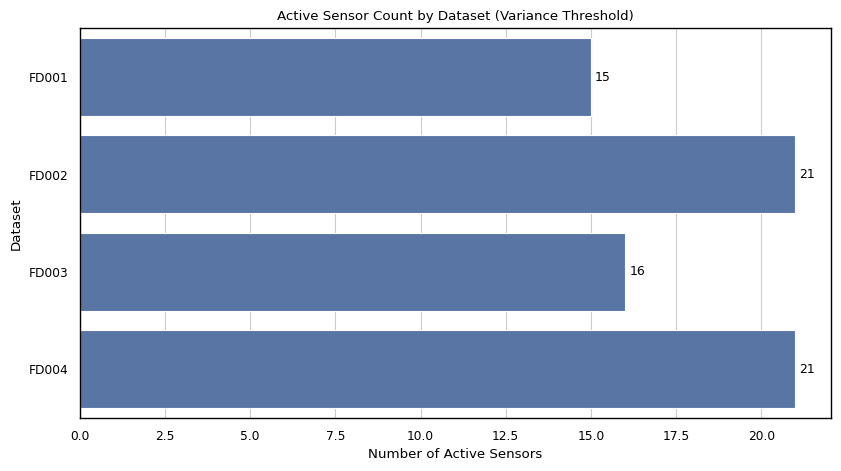

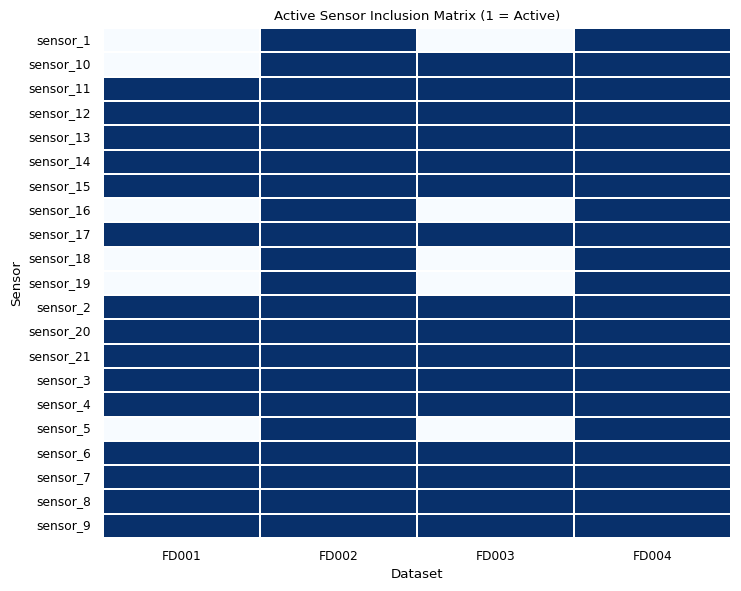

In [ ]:
fds = ["FD001", "FD002", "FD003", "FD004"]

tau = 1e-6          # Variance threshold for "active" sensors
m = 8               # Top-m sensors by |corr| for HI candidates

def get_sensor_cols(df: pd.DataFrame):
    return [c for c in df.columns if c.startswith("sensor_")]

sensor_inclusion = {}
active_rows = []
hi_rows = []

for fd in fds:
    train_df_d, test_df_d, rul_df_d, meta_d = data_cache[fd]
    sensor_cols = get_sensor_cols(train_df_d)

    # Active sensors via variance threshold
    var_s = train_df_d[sensor_cols].var()
    active = var_s[var_s >= tau].sort_values(ascending=False).index.tolist()
    sensor_inclusion[fd] = set(active)

    # Correlation ranking (filter to active sensors to avoid runtime warnings)
    X = train_df_d[active]
    y = train_df_d["RUL"]

    pearson_corr = X.corrwith(y, method="pearson").dropna()
    spearman_corr = X.corrwith(y, method="spearman").dropna()

    top_p = pearson_corr.abs().sort_values(ascending=False).head(m).index.tolist()
    top_s = spearman_corr.abs().sort_values(ascending=False).head(m).index.tolist()

    active_rows.append({
        "dataset": fd,
        "tau": tau,
        "n_active_sensors": int(len(active)),
        "active_sensors": ", ".join(active),
    })

    hi_rows.append({
        "dataset": fd,
        "m": m,
        "hi_sensors_pearson_top_abs_corr": ", ".join(top_p),
        "hi_sensors_spearman_top_abs_corr": ", ".join(top_s),
        "overlap_count": int(len(set(top_p) & set(top_s))),
    })

active_df = pd.DataFrame(active_rows).set_index("dataset")
hi_df = pd.DataFrame(hi_rows).set_index("dataset")

display(active_df)
display(hi_df)

# Graph 1: Active sensor counts
plt.figure(figsize=(8.5, 4.8))
ax = sns.barplot(
    data=active_df.reset_index(),
    y="dataset",
    x="n_active_sensors",
    orient="h"
)
ax.set_title("Active Sensor Count by Dataset (Variance Threshold)")
ax.set_xlabel("Number of Active Sensors")
ax.set_ylabel("Dataset")

for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=3, fontsize=9)

plt.tight_layout()
plt.show()

# Graph 2: Active sensor inclusion heatmap (1=active)
all_sensors = sorted({s for fd in sensor_inclusion for s in sensor_inclusion[fd]})

inc = pd.DataFrame(index=all_sensors, columns=fds)
for fd in fds:
    inc[fd] = [1 if s in sensor_inclusion[fd] else 0 for s in inc.index]

plt.figure(figsize=(7.5, max(6, len(all_sensors) * 0.25)))
sns.heatmap(
    inc,
    cmap="Blues",
    cbar=False,
    linewidths=0.2,
    linecolor="white"
)
plt.title("Active Sensor Inclusion Matrix (1 = Active)")
plt.xlabel("Dataset")
plt.ylabel("Sensor")
plt.tight_layout()
plt.show()

## Per-Dataset Eda (FD002, FD003, FD004)

Each subsection applies the same EDA visuals used for FD001 to enable direct comparisons.

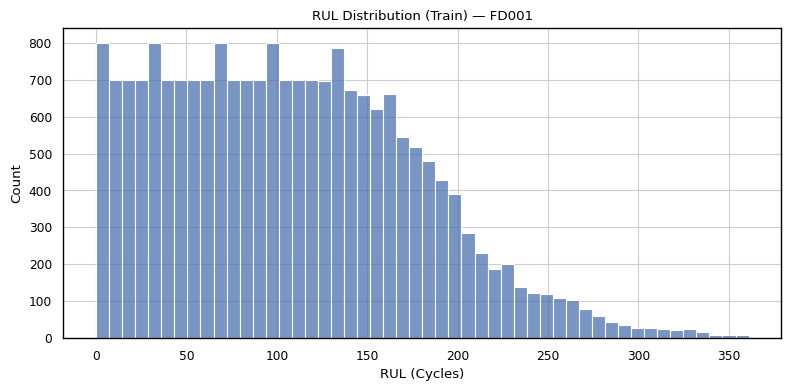

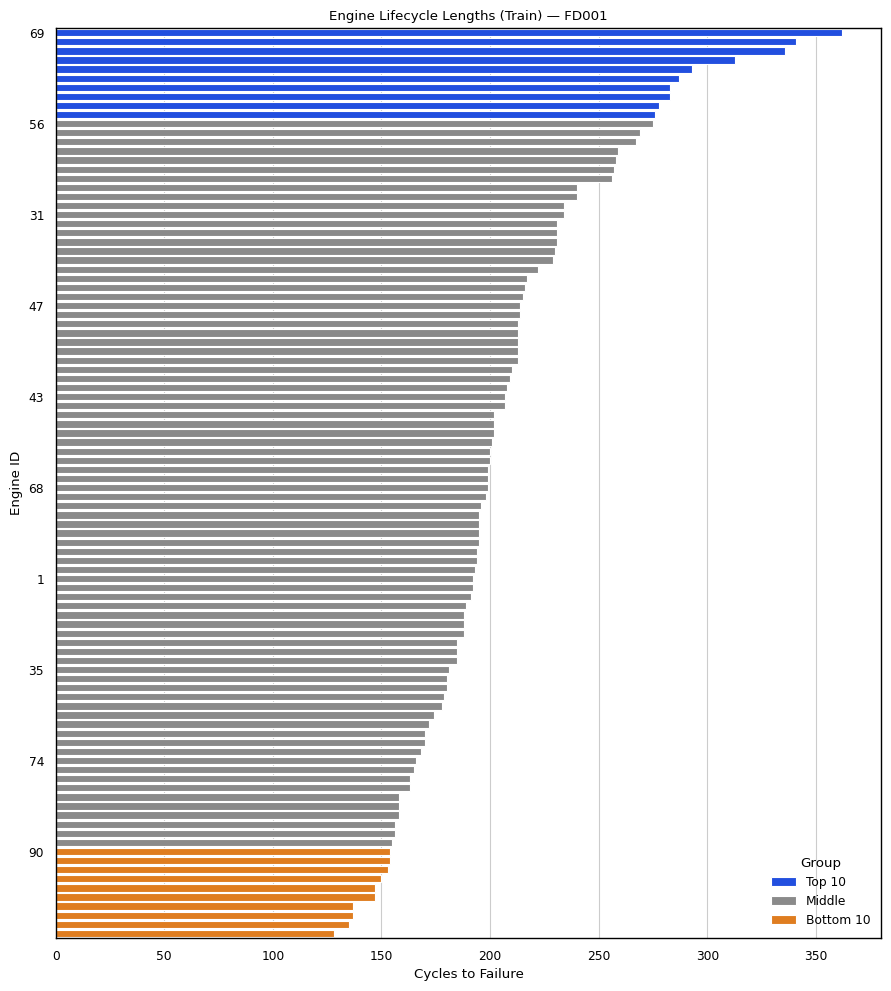

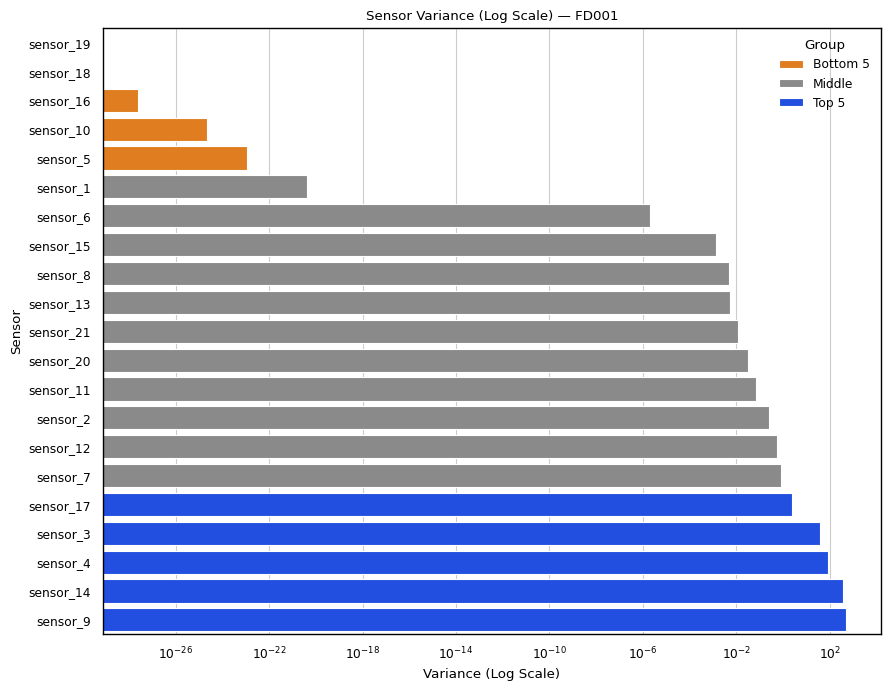

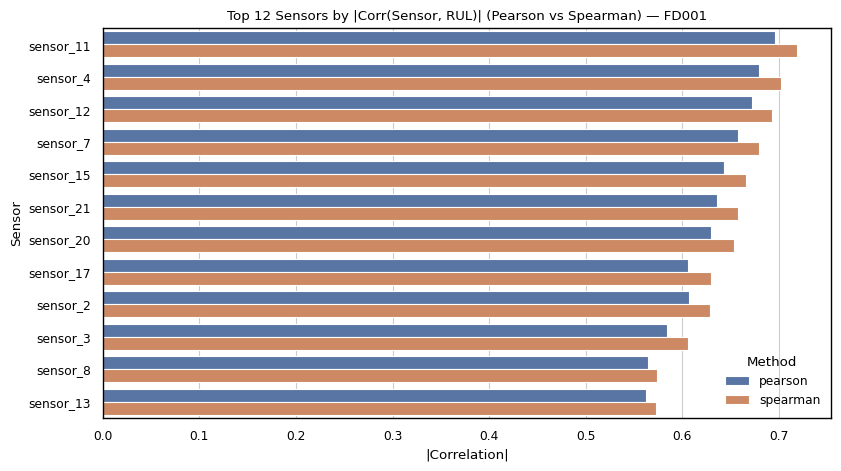

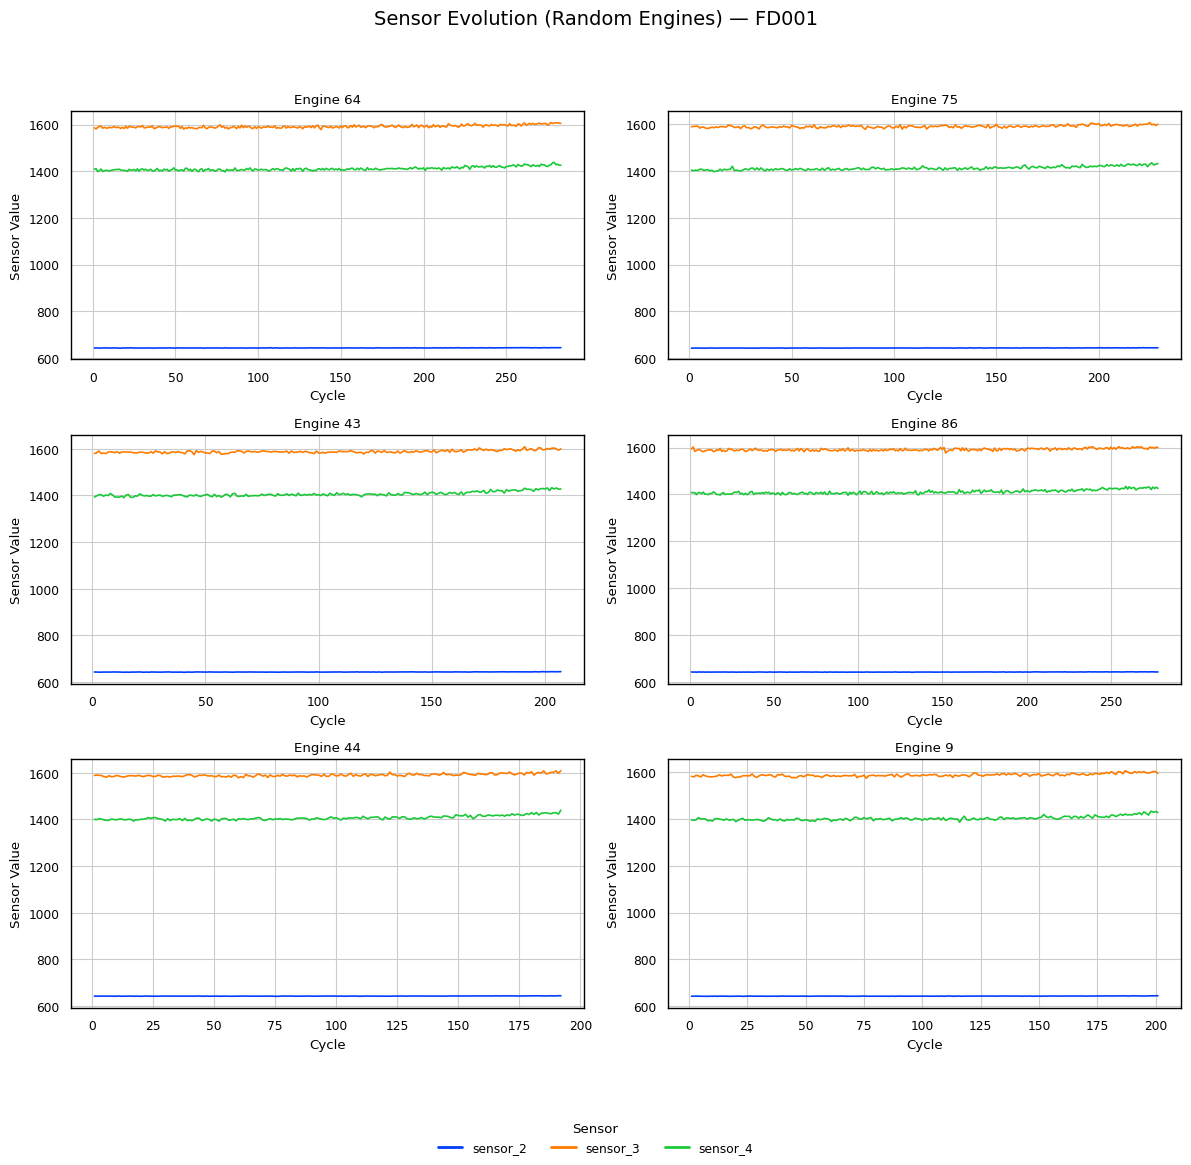

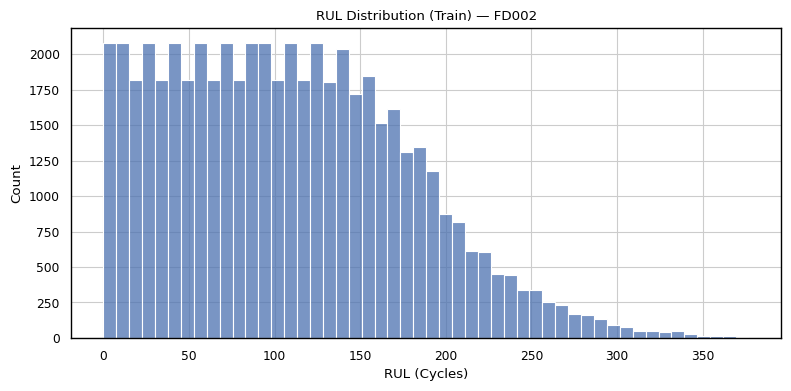

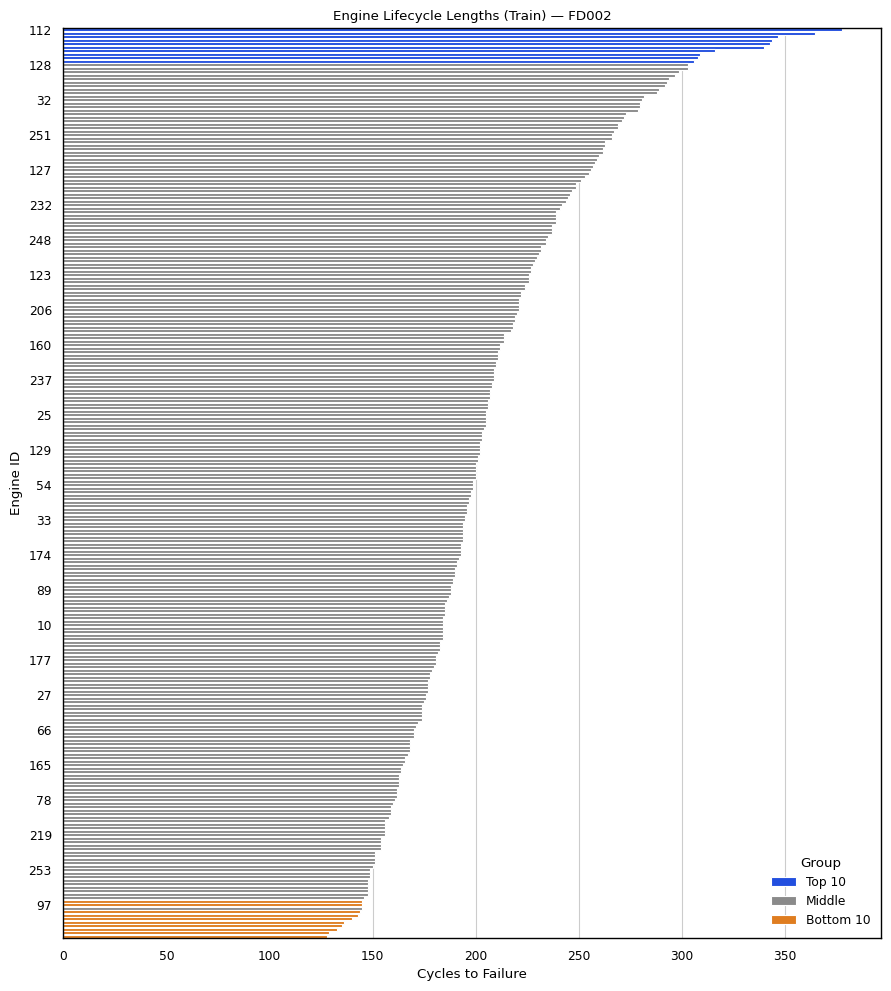

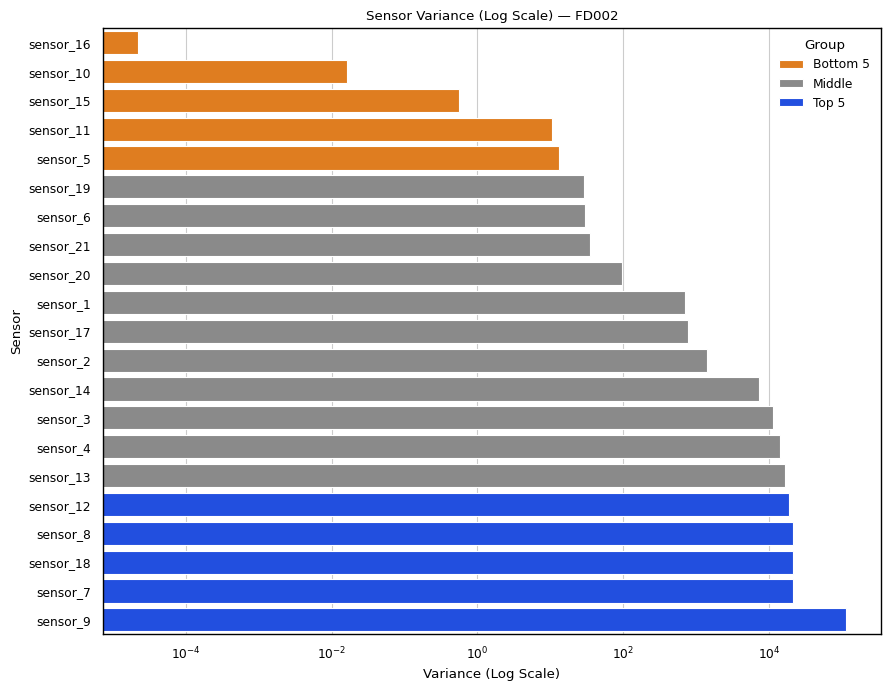

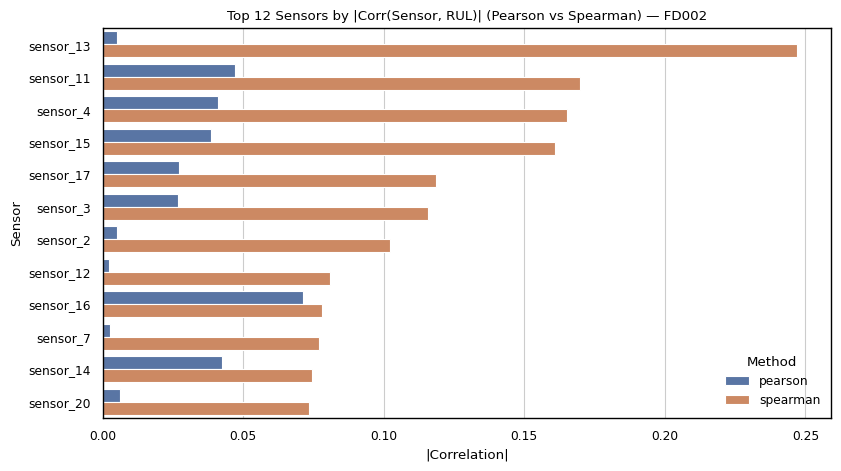

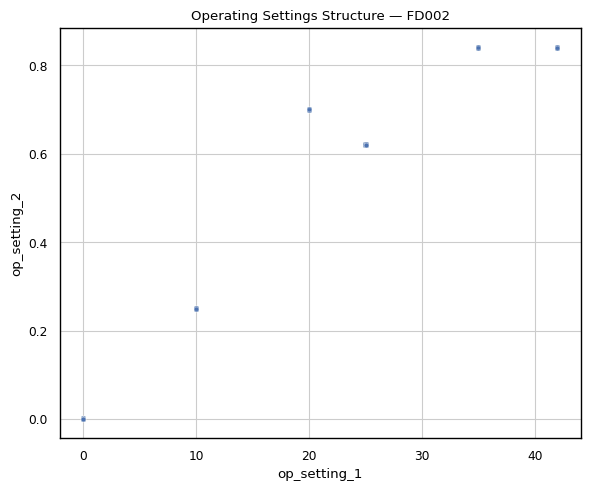

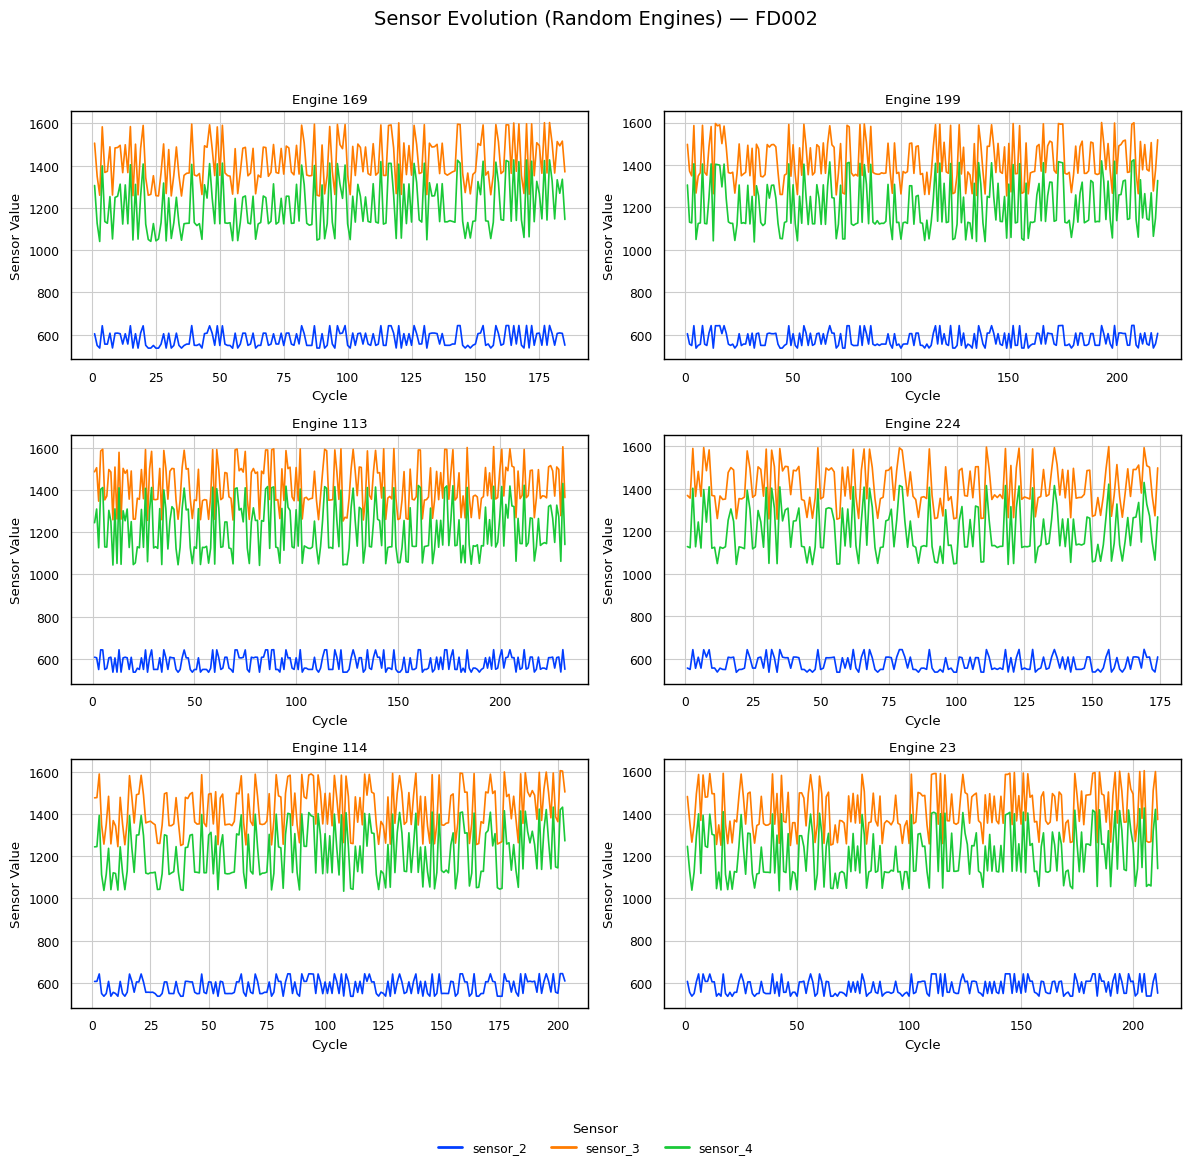

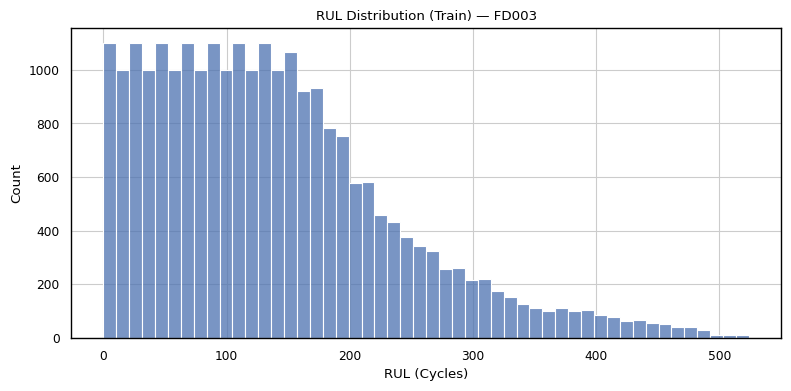

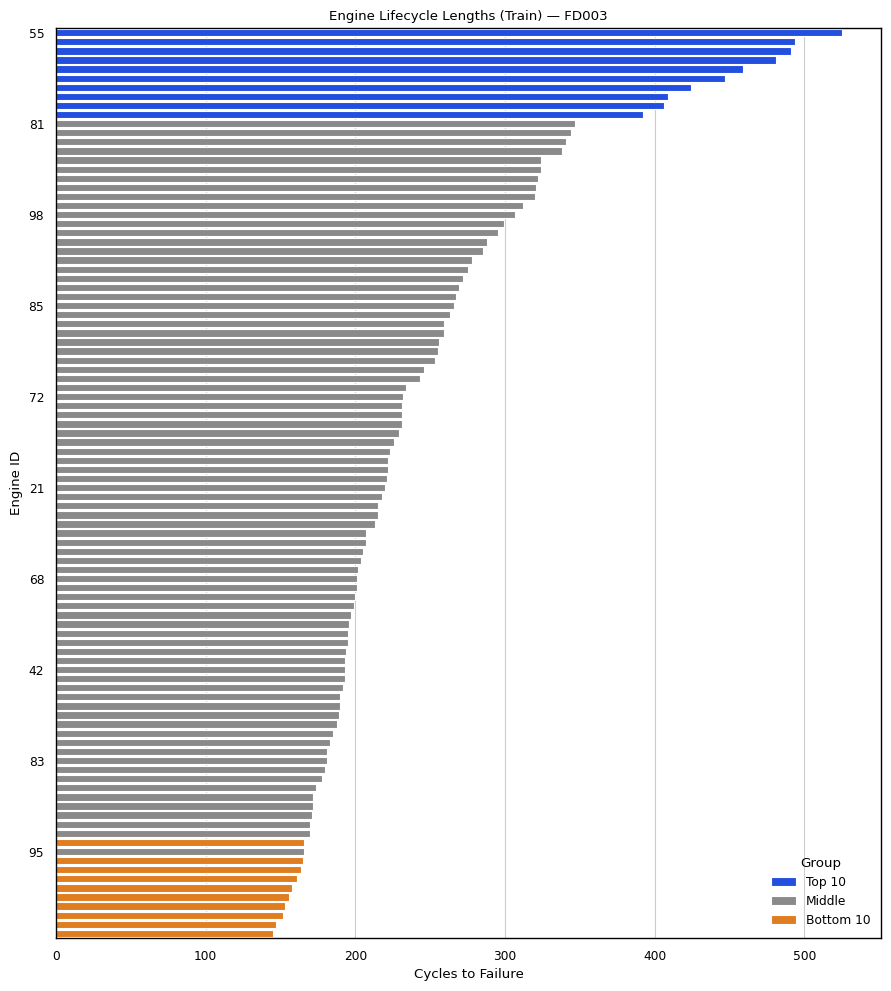

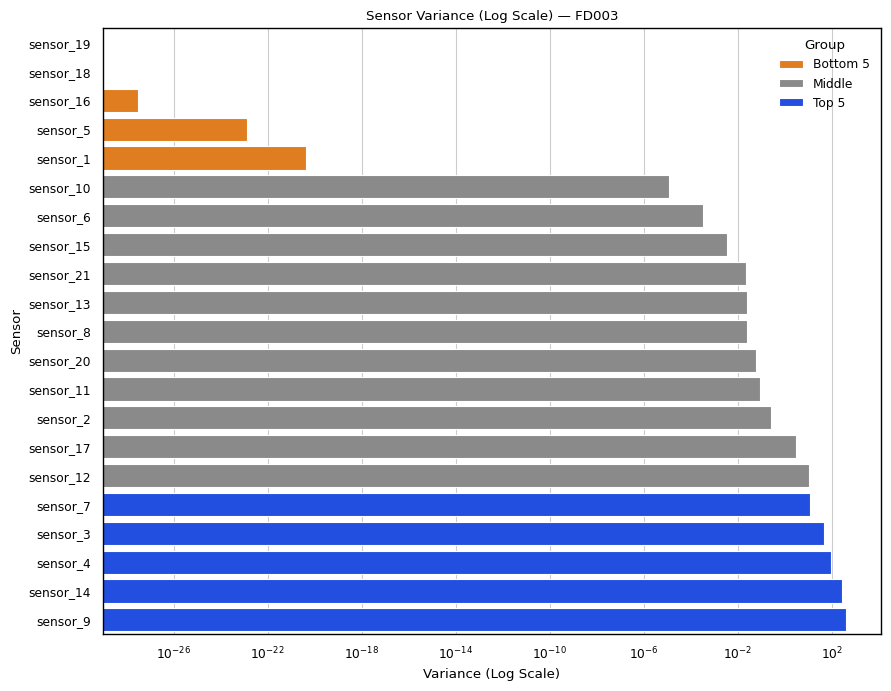

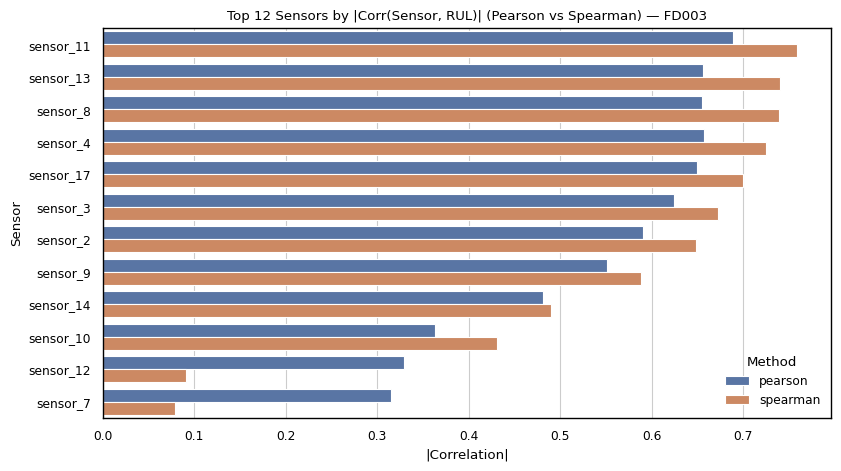

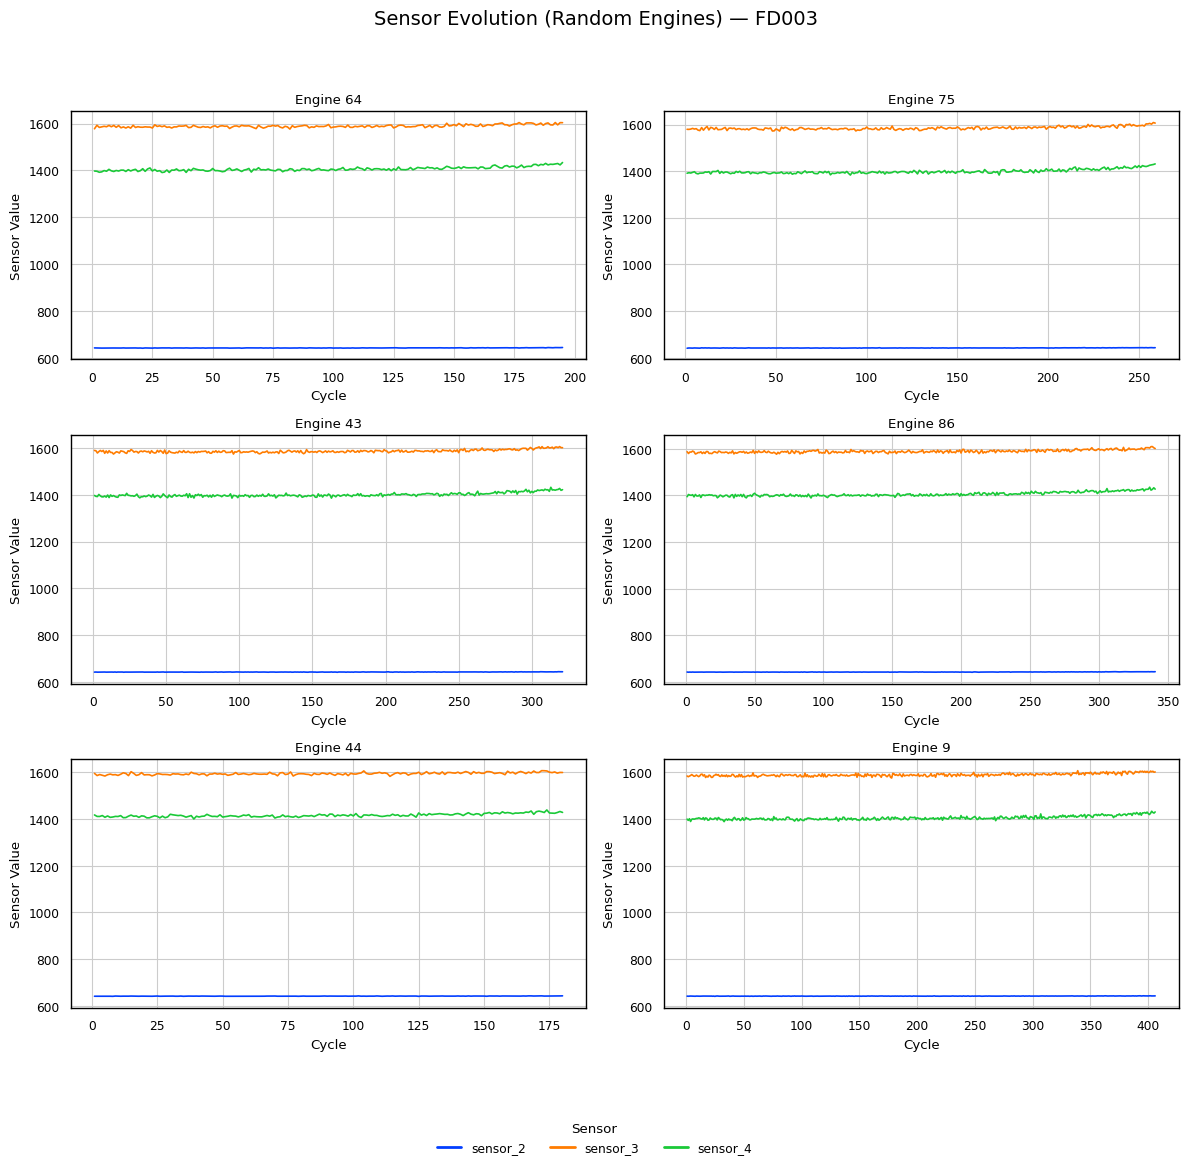

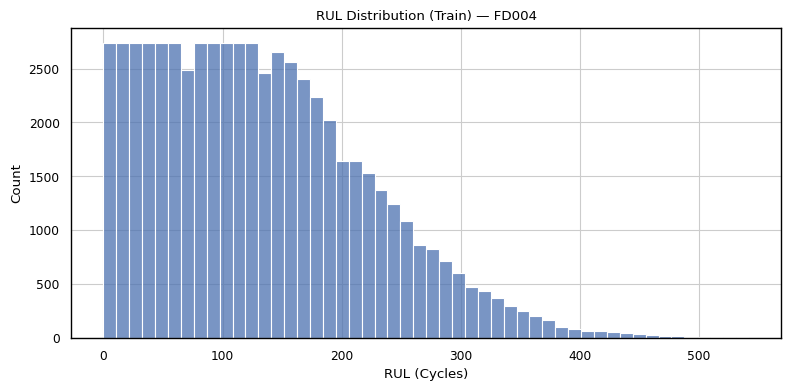

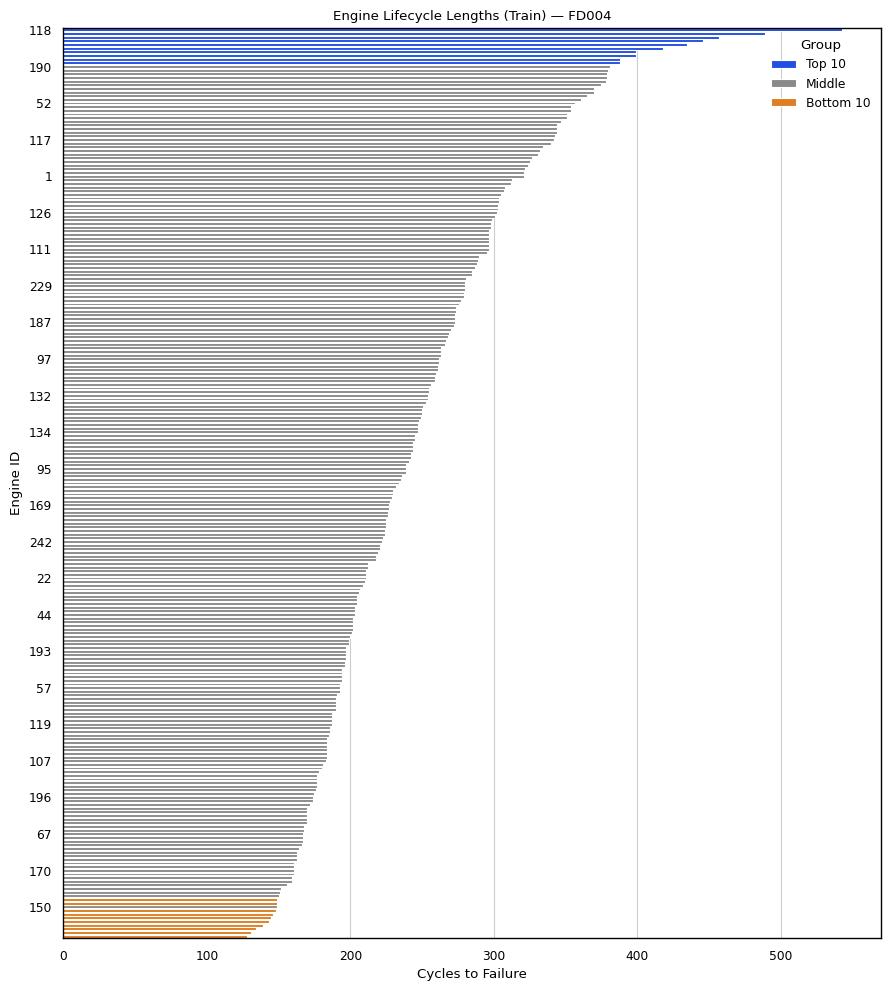

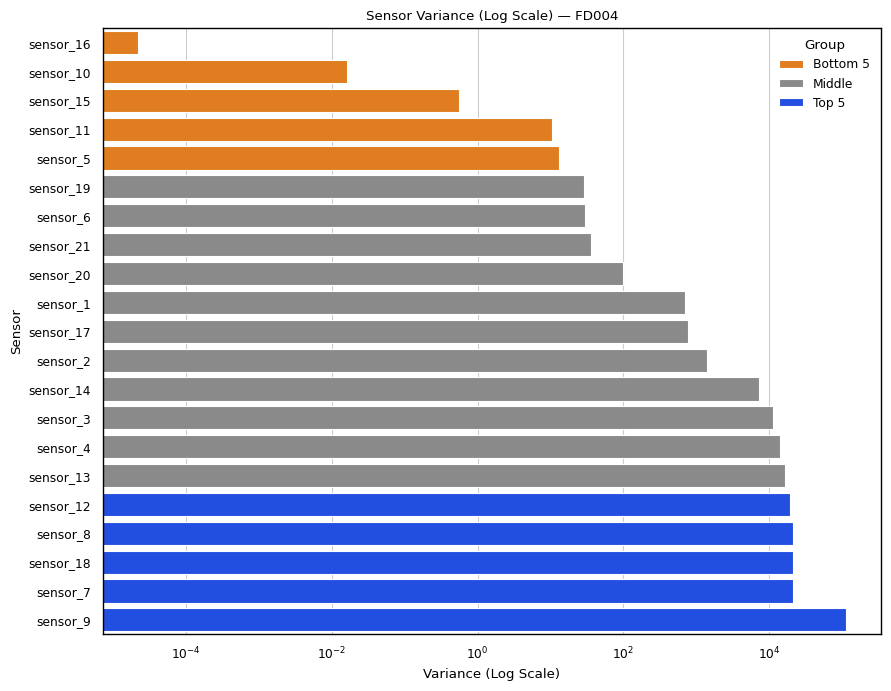

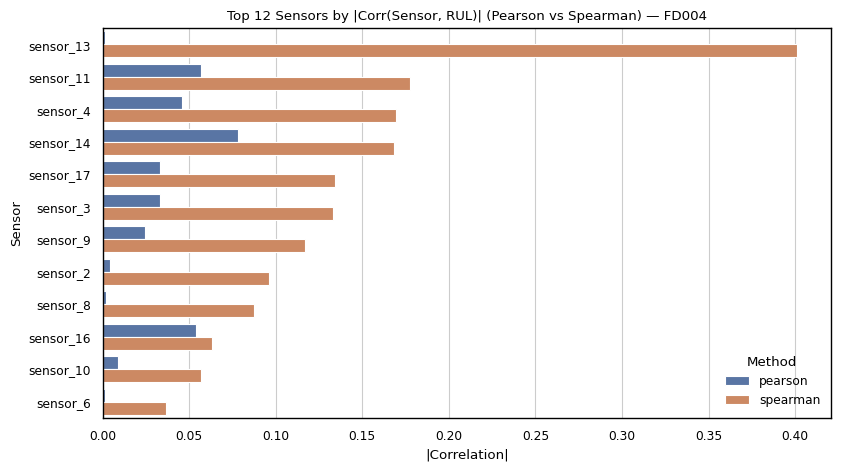

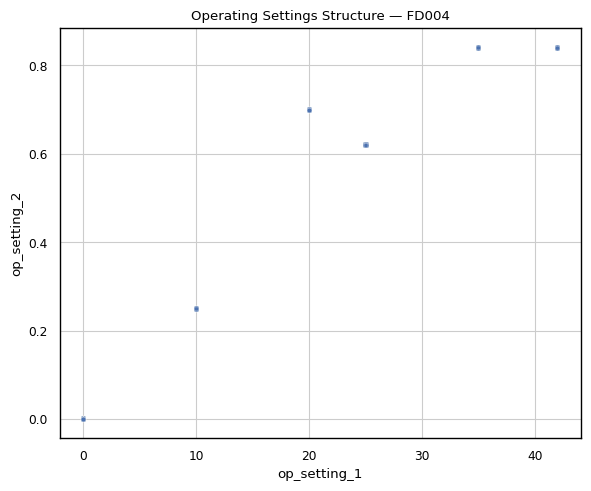

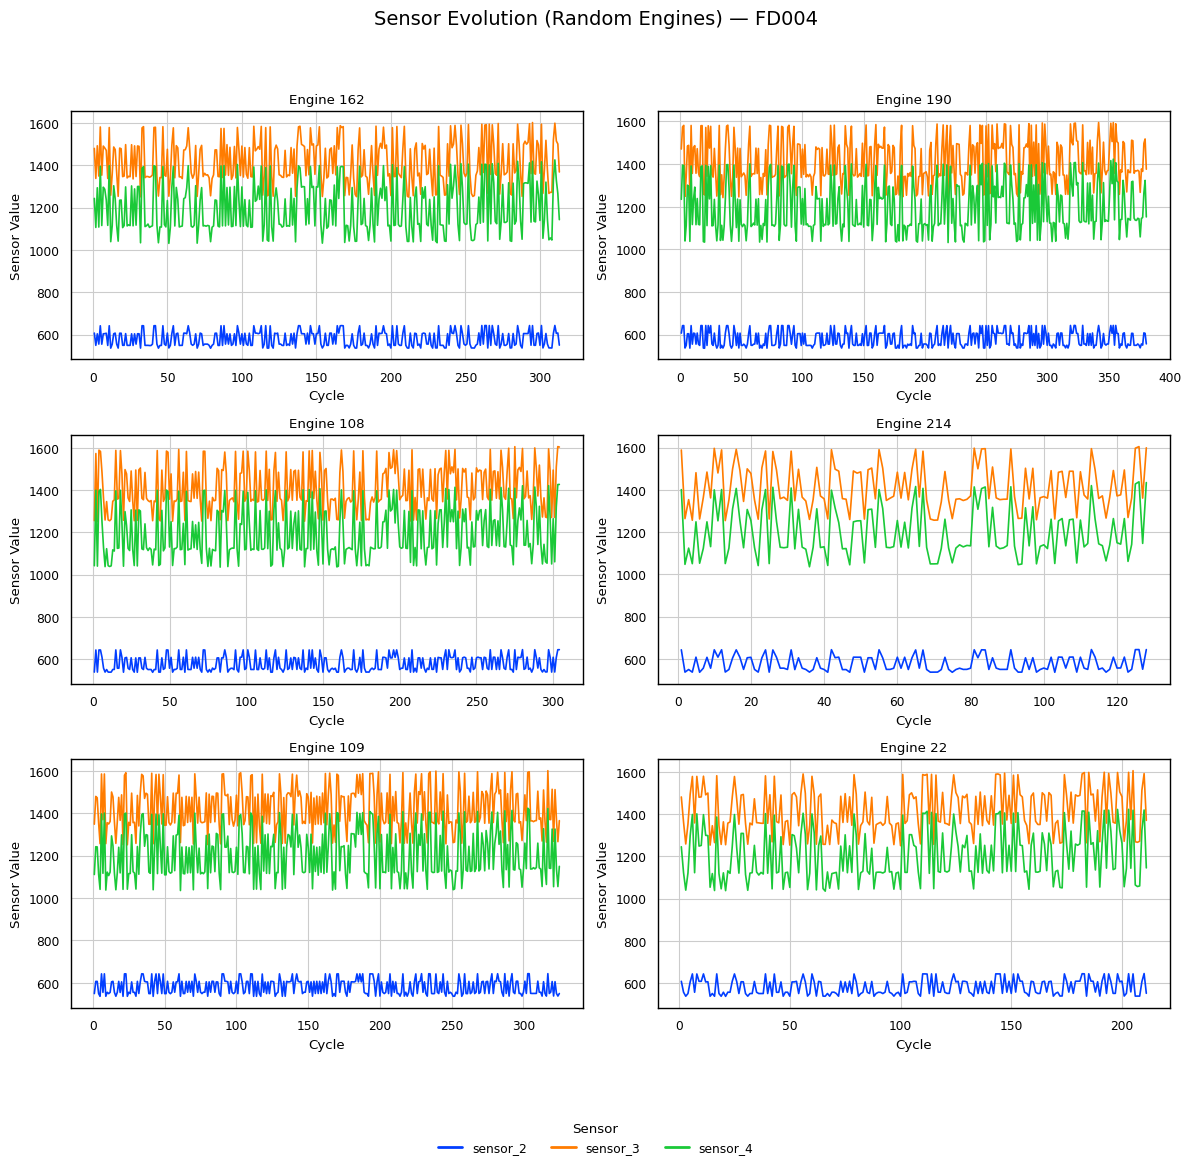

In [ ]:
for fd in ["FD001","FD002","FD003","FD004"]:
    train_df_d, test_df_d, rul_df_d, meta_d = load_fd(fd)
    title = f"— {fd}"

    # Core distributions
    plot_rul_distribution(train_df_d, title_suffix=title)
    plot_lifecycle_lengths(train_df_d, k=10, title_suffix=title)

    # Sensor variance profile
    _ = plot_sensor_variance(train_df_d, k=5, title_suffix=title)

    # Sensor–RUL correlation ranking (useful before feature selection)
    plot_sensor_rul_corr_compare(train_df_d, top_k=12, title_suffix=title)


    # Operating settings structure (multi-regime datasets)
    if fd in ["FD002","FD004"]:
        plot_operating_settings(train_df_d, title_suffix=title)

    # Random-engine sensor evolution (raw)
    plot_random_engines_sensors(train_df_d, sensors_to_plot=("sensor_2","sensor_3","sensor_4"), n_engines=6, seed=42, title_suffix=title)


## FD00x Summary

**Structure**
- Multivariate time series with variable-length engine trajectories.
- Dataset-specific operating conditions and fault modes define the data-generating process.

**Signal characteristics**
- Sensor variance and correlation patterns differ substantially across datasets.
- RUL distributions are right-skewed with dataset-dependent ranges.

**Implications**
- Feature relevance is dataset-conditional.
- Sensors informative in one FD may be uninformative in another.


### Sensor–RUL Correlation (pre–Feature Selection)

For each sensor $s$, Pearson correlation with Remaining Useful Life (RUL) is computed as:

$$
\rho_s = \frac{\mathrm{Cov}(x_s, \mathrm{RUL})}{\sigma_{x_s}\,\sigma_{\mathrm{RUL}}}
$$

Sensors with high $|\rho_s|$ indicate strong monotonic association with degradation progression.

This ranking is useful prior to feature selection because:
- It filters sensors that do not encode degradation information.
- It reduces model complexity before temporal windowing.
- It highlights dataset-specific degradation signatures.

## What This Notebook Does Not Do

- ❌ Train models  
- ❌ Tune hyperparameters  
- ❌ Produce performance claims  
- ❌ Make deployment assumptions  

These are intentionally deferred to later FusionCore stages.


## Summary for FusionCore v0

This notebook contributes:

- Diagnostic evidence for dataset structure and variability across FD001–FD004
- Identified sources of sensor instability and potential failure-mode ambiguity
- Constraints and hypotheses to test in benchmarking notebooks

Next step: implement model benchmarking under identical splits/features and evaluate stability and error modes (TFT vs TS Mixer vs AutoGluon).
